In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch

from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree_torch import Tree
from SLCVI_torch import SLCVI

import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy

np.random.seed(0)

In [3]:
pop_size = 0.1 # exponential parameter for constant pop size prior
n_species = 4 # number of species
n_genes = 100 # number of genes

# draw a tree from prior

In [4]:
def draw_log_times_prior(pop_size,n_species):

    # draw coal_times first
    coal_times = []
    for k in range(n_species,1,-1):
        scale_k = 2*pop_size/(k*(k-1))
        coal_times.append(np.random.exponential(scale = scale_k))

    coal_times = np.cumsum(coal_times)

    # now population log_times with coal_time
    log_times = np.zeros((n_species,n_species))
    species = [{i} for i in range(n_species)]
    for coal_time in coal_times:
        species_to_join = np.random.choice(species,2,replace=False)
        for i in species_to_join[0]:
            for j in species_to_join[1]:
                log_times[max(i,j),min(i,j)] = np.log(coal_time)

        new_species = species_to_join[0].union(species_to_join[1])
        species.remove(species_to_join[0])
        species.remove(species_to_join[1])
        species.append(new_species)
        
    log_times[np.triu_indices(n_species)] = max(coal_times)
        
    return log_times

In [5]:
log_times = draw_log_times_prior(pop_size,n_species)
log_times = torch.tensor(log_times)

theta = torch.zeros((2,n_species,n_species))

theta[0] = log_times
theta[0] = theta[0]*torch.tril(torch.ones((n_species,n_species)),diagonal=-1)

theta[1] = -1*torch.ones((n_species,n_species))
theta[1] = theta[1]*torch.tril(torch.ones((n_species,n_species)),diagonal=-1)

genomes = [['A'] for _ in range(n_species)]

nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = torch.tensor([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = torch.float64)
tree_log_probs = torch.log(tree_log_probs)

In [6]:
real_tree = Tree(theta,log_times,
                 tree_log_probs,
                 pop_size=pop_size)

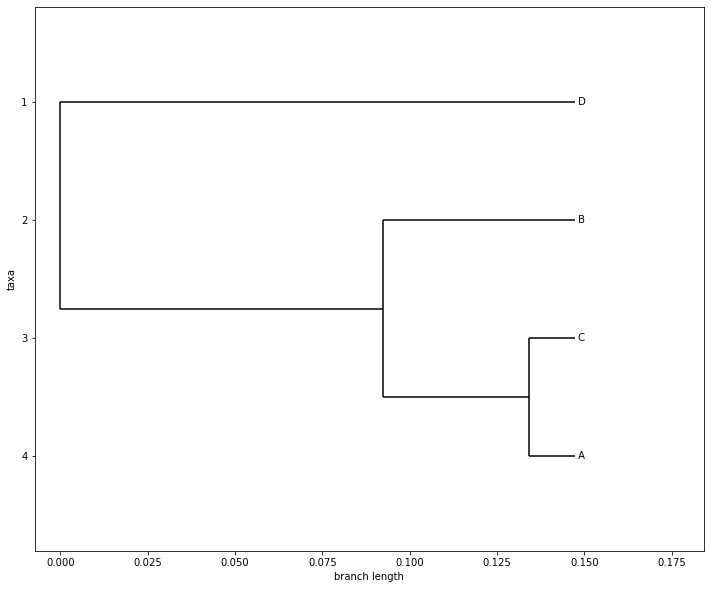

In [7]:
species = ['A','B','C','D']


def write_newick(node):
    
    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time.item())
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time.item() - node.coal_time.item()
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)
treedata = write_newick(real_tree.nodes[-1])
handle = StringIO(treedata)
tree_to_draw = Phylo.read(handle, "newick")

# Set up the plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

# Draw the phylogenetic tree
Phylo.draw(tree_to_draw, axes=ax)

# Draw a Genome from the tree

In [8]:
root_genome = [np.random.choice(['A','T','G','C']) for _ in range(n_genes)]
real_tree.nodes[-1].genome = root_genome

In [9]:
def sample_children_genome(node):
    
    if node.children == []:
        return
    
    else:
        # sample genome 1
        bl1 = node.coal_time - node.children[0].coal_time
        q1 = 0.25-0.25*np.exp(-bl1)
        p1 = 0.25+0.75*np.exp(-bl1)
        P1 = {'A':[p1,q1,q1,q1],
              'T':[q1,p1,q1,q1],
              'G':[q1,q1,p1,q1],
              'C':[q1,q1,q1,p1]}
        
        node.children[0].genome = [np.random.choice(['A','T','G','C'],p = P1[g]) for g in node.genome]
        sample_children_genome(node.children[0])
        
        # sample genome 2
        bl2 = node.coal_time - node.children[1].coal_time
        q2 = 0.25-0.25*np.exp(-bl1)
        p2 = 0.25+0.75*np.exp(-bl1)
        P2 = {'A':[p2,q2,q2,q2],
              'T':[q2,p2,q2,q2],
              'G':[q2,q2,p2,q2],
              'C':[q2,q2,q2,p2]}
        
        node.children[1].genome = [np.random.choice(['A','T','G','C'],p = P2[g]) for g in node.genome]
        sample_children_genome(node.children[1])
    
# start recursion
sample_children_genome(real_tree.nodes[-1])
genomes = [leaf.genome for leaf in real_tree.leaves]

In [10]:
for i in range(4):
    for j in range(i):
        print(i,j)
        print(np.mean([x==y for x,y in zip(genomes[i],genomes[j])]))
        print("")

1 0
0.93

2 0
0.98

2 1
0.93

3 0
0.76

3 1
0.75

3 2
0.75



# Run variational inference using the simulated genome

In [11]:
# draw a new theta
log_times = draw_log_times_prior(pop_size,n_species)
log_times = torch.tensor(log_times)

theta = torch.zeros((2,n_species,n_species))

theta[0] = log_times
theta[0] = theta[0]*torch.tril(torch.ones((n_species,n_species)),diagonal=-1)

theta[1] = -1*torch.ones((n_species,n_species))
theta[1] = theta[1]*torch.tril(torch.ones((n_species,n_species)),diagonal=-1)

print(theta)

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.4276,  0.0000,  0.0000,  0.0000],
         [-4.5392, -3.4276,  0.0000,  0.0000],
         [-2.2685, -2.2685, -2.2685,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.0000, -0.0000, -0.0000, -0.0000],
         [-1.0000, -1.0000, -0.0000, -0.0000],
         [-1.0000, -1.0000, -1.0000, -0.0000]]])


In [12]:
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = torch.tensor([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = torch.float64)
tree_log_probs = torch.log(tree_log_probs)

iteration:  0
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.5276,  0.0000,  0.0000,  0.0000],
         [-4.6392, -3.5276,  0.0000,  0.0000],
         [-2.1685, -2.1685, -2.1685,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.1000, -0.0000, -0.0000, -0.0000],
         [-1.1000, -1.1000, -0.0000, -0.0000],
         [-1.1000, -1.1000, -1.1000, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.4784,  0.0000,  0.0000,  0.0000],
         [ 2.2976,  1.3781,  0.0000,  0.0000],
         [-6.5124, -7.4837, -0.7964,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.8810,  0.0000,  0.0000,  0.0000],
         [ 1.4847,  0.2075,  0.0000,  0.0000],
         [ 3.4332,  2.1615,  0.3299,  0.0000]]])
ELBO estimate:  -270.8810413422064

iteration:  10
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
   

iteration:  90
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4832,  0.0000,  0.0000,  0.0000],
         [-4.7821, -3.4486,  0.0000,  0.0000],
         [-1.3811, -1.4430, -1.9742,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1601, -0.0000, -0.0000, -0.0000],
         [-2.7357, -3.5188, -0.0000, -0.0000],
         [-1.9818, -2.0125, -3.9784, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.1550e-14,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-3.2794e-02,  2.7078e-02,  0.0000e+00,  0.0000e+00],
         [ 4.2772e-04,  1.6628e-03, -3.3635e-02,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.8596e-14,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.6970e-02,  9.3242e-03,  0.0000e+00,  0.0000e+00],
         [-2.4549e-04, -8.5225e-04,  9.6043e-03,  0.0000e+00]]])
ELBO estimate:  -2

iteration:  180
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7830, -3.4533,  0.0000,  0.0000],
         [-1.3872, -1.4776, -1.9593,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-3.1125, -3.8701, -0.0000, -0.0000],
         [-1.9744, -1.9509, -4.3388, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0660e-14,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.9455e-02,  6.9676e-02,  0.0000e+00,  0.0000e+00],
         [ 7.4012e-04,  1.0301e-02,  2.1046e-01,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-9.9459e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.0691e-03,  3.6036e-03,  0.0000e+00,  0.0000e+00],
         [-4.1582e-04, -4.8749e-03,  5.1354e-03,  0.0000e+00]]])
ELBO estimate:  -

iteration:  270
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7655, -3.4324,  0.0000,  0.0000],
         [-1.4359, -1.9892, -1.4669,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-3.3810, -4.1480, -0.0000, -0.0000],
         [-1.9264, -3.6493, -4.4002, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.2277e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.7090e-02,  1.0053e-01,  0.0000e+00,  0.0000e+00],
         [ 2.8576e-03, -4.0110e-01,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-4.0351e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.4925e-03, -1.2310e-04,  0.0000e+00,  0.0000e+00],
         [-1.5242e-03,  6.3883e-03,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

iteration:  360
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7705, -3.4497,  0.0000,  0.0000],
         [-1.5819, -2.0338, -1.4575,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-3.5774, -4.3406, -0.0000, -0.0000],
         [-1.7796, -4.2340, -4.3989, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.4822e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 9.4945e-03,  6.9342e-03,  0.0000e+00,  0.0000e+00],
         [-1.0727e+01,  1.0507e+01,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.4343e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.2574e-03,  2.1599e-03,  0.0000e+00,  0.0000e+00],
         [ 2.7116e+00,  2.1308e-02,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

iteration:  450
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7628, -3.4439,  0.0000,  0.0000],
         [-0.4578, -1.9592, -1.4575,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-3.7410, -4.4954, -0.0000, -0.0000],
         [-2.5920, -4.4735, -4.3989, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.5217e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.3257e-02, -1.9942e-02,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  4.7723e-02,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.4184e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.7359e-03,  1.0247e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  3.3225e-03,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

iteration:  540
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7679, -3.4482,  0.0000,  0.0000],
         [-0.4577, -1.9670, -1.4575,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-3.8716, -4.6316, -0.0000, -0.0000],
         [-2.5921, -4.6514, -4.3989, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 9.9450e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-5.3320e-03, -9.1321e-02,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  9.1120e-02,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-9.6854e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 7.0210e-04,  9.1482e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  4.1085e-03,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

iteration:  630
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7721, -3.4458,  0.0000,  0.0000],
         [-0.4577, -1.9596, -1.4575,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-3.9840, -4.7477, -0.0000, -0.0000],
         [-2.5921, -4.7987, -4.3989, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.0441e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.1060e-03, -5.2934e-02,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.9260e-01,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.9663e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 4.2321e-04,  1.1459e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.8687e-03,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

iteration:  720
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7687, -3.4567,  0.0000,  0.0000],
         [-0.4577, -1.9662, -1.4575,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-4.0849, -4.8501, -0.0000, -0.0000],
         [-2.5921, -4.9230, -4.3989, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.2867e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-4.3044e-03, -6.7066e-02,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.4652e-02,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.2475e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.1467e-04,  5.8637e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.3245e-03,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

iteration:  810
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7727, -3.4483,  0.0000,  0.0000],
         [-0.4577, -1.9591, -1.4575,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-4.1793, -4.9417, -0.0000, -0.0000],
         [-2.5921, -5.0179, -4.3989, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 2.5525e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.5157e-02,  7.0381e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  3.9846e-02,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-2.4498e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 8.5306e-04,  6.4766e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  7.7606e-04,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

iteration:  900
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7754, -3.4505,  0.0000,  0.0000],
         [-0.4577, -1.9623, -1.4575,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-4.2592, -5.0235, -0.0000, -0.0000],
         [-2.5921, -5.1124, -4.3989, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.8279e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.6480e-02, -1.3614e-02,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.1244e-02,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.7662e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.4001e-04,  2.6006e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  5.3687e-04,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

iteration:  990
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.4829,  0.0000,  0.0000,  0.0000],
         [-4.7742, -3.4517,  0.0000,  0.0000],
         [-0.4577, -1.9609, -1.4575,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-2.1603, -0.0000, -0.0000, -0.0000],
         [-4.3410, -5.0985, -0.0000, -0.0000],
         [-2.5921, -5.1966, -4.3989, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.7777e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-4.1933e-03, -2.7090e-02,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.8290e-02,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-1.7172e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 3.0426e-04,  3.4587e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  4.8707e-04,  0.0000e+00,  0.0000e+00]]])
ELBO estimate:  -

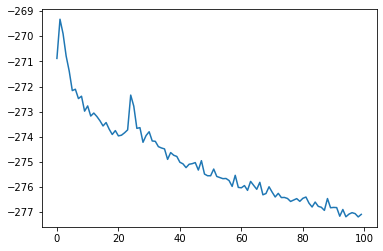

In [13]:
optim_reparam = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reparam.learn(batch_size=10,
                      iters=1000,
                      alpha=0.1,
                      method="reparam",
                      record_every=10,
                      pop_size=pop_size)

print("final theta:",optim_reparam.theta)
print("final gradient:",optim_reparam.theta.grad)
plt.plot(optim_reparam.ELBO_ests)

iteration:  0
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.5276,  0.0000,  0.0000,  0.0000],
         [-4.6392, -3.5276,  0.0000,  0.0000],
         [-2.1685, -2.1685, -2.1685,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.1000, -0.0000, -0.0000, -0.0000],
         [-1.1000, -1.1000, -0.0000, -0.0000],
         [-0.9000, -0.9000, -0.9000, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.9930,  0.0000,  0.0000,  0.0000],
         [ 0.6564,  0.9930,  0.0000,  0.0000],
         [-2.5889, -2.5889, -2.5889,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2094,  0.0000,  0.0000,  0.0000],
         [ 0.2693,  0.2094,  0.0000,  0.0000],
         [-0.6529, -0.6529, -0.6529,  0.0000]]])
ELBO estimate:  -272.2534372769465

iteration:  10
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
   

iteration:  100
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.0432,  0.0000,  0.0000,  0.0000],
         [-4.4745, -3.0821,  0.0000,  0.0000],
         [-1.6402, -1.6402, -1.6402,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-0.9343, -0.0000, -0.0000, -0.0000],
         [-0.7184, -0.9074, -0.0000, -0.0000],
         [-1.3349, -1.3349, -1.3349, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1094,  0.0000,  0.0000,  0.0000],
         [-0.0950,  0.1096,  0.0000,  0.0000],
         [ 0.0093,  0.0093,  0.0093,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0365,  0.0000,  0.0000,  0.0000],
         [-0.1160,  0.0428,  0.0000,  0.0000],
         [-0.0030, -0.0030, -0.0030,  0.0000]]])
ELBO estimate:  -267.13682819635187

iteration:  110
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],

iteration:  200
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-2.9865,  0.0000,  0.0000,  0.0000],
         [-4.5028, -3.0847,  0.0000,  0.0000],
         [-1.6536, -1.6536, -1.6536,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-0.9122, -0.0000, -0.0000, -0.0000],
         [-0.6974, -0.8617, -0.0000, -0.0000],
         [-1.2948, -1.2948, -1.2948, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.5882,  0.0000,  0.0000,  0.0000],
         [-0.6690,  0.5741,  0.0000,  0.0000],
         [-0.4454, -0.4454, -0.4454,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3309,  0.0000,  0.0000,  0.0000],
         [-0.8763,  0.4069,  0.0000,  0.0000],
         [ 0.0214,  0.0214,  0.0214,  0.0000]]])
ELBO estimate:  -267.0978686881009

iteration:  210
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],


iteration:  300
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.0495,  0.0000,  0.0000,  0.0000],
         [-4.6406, -3.1184,  0.0000,  0.0000],
         [-1.6306, -1.6306, -1.6306,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.0518, -0.0000, -0.0000, -0.0000],
         [-0.7910, -1.0472, -0.0000, -0.0000],
         [-1.2236, -1.2236, -1.2236, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1414,  0.0000,  0.0000,  0.0000],
         [-0.1405,  0.1650,  0.0000,  0.0000],
         [ 0.4182,  0.4182,  0.4182,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0109,  0.0000,  0.0000,  0.0000],
         [-0.1980,  0.0029,  0.0000,  0.0000],
         [ 0.0913,  0.0913,  0.0913,  0.0000]]])
ELBO estimate:  -267.07614321532714

iteration:  310
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],

iteration:  400
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.0868,  0.0000,  0.0000,  0.0000],
         [-4.5008, -3.0884,  0.0000,  0.0000],
         [-1.6486, -1.6486, -1.6486,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.0150, -0.0000, -0.0000, -0.0000],
         [-0.6311, -0.9574, -0.0000, -0.0000],
         [-1.3552, -1.3552, -1.3552, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0963,  0.0000,  0.0000,  0.0000],
         [-0.2663, -0.0882,  0.0000,  0.0000],
         [ 0.2667,  0.2667,  0.2667,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0148,  0.0000,  0.0000,  0.0000],
         [-0.2653, -0.0158,  0.0000,  0.0000],
         [ 0.0031,  0.0031,  0.0031,  0.0000]]])
ELBO estimate:  -266.9931444137909

iteration:  410
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],


iteration:  500
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.0363,  0.0000,  0.0000,  0.0000],
         [-4.3954, -3.0360,  0.0000,  0.0000],
         [-1.6799, -1.6799, -1.6799,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.0094, -0.0000, -0.0000, -0.0000],
         [-0.5011, -1.0064, -0.0000, -0.0000],
         [-1.3445, -1.3445, -1.3445, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0521,  0.0000,  0.0000,  0.0000],
         [-0.0712,  0.0516,  0.0000,  0.0000],
         [-0.0550, -0.0550, -0.0550,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0279,  0.0000,  0.0000,  0.0000],
         [-0.0593,  0.0275,  0.0000,  0.0000],
         [-0.0042, -0.0042, -0.0042,  0.0000]]])
ELBO estimate:  -267.1758637871198

iteration:  510
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],


iteration:  600
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.0124,  0.0000,  0.0000,  0.0000],
         [-4.5987, -3.1392,  0.0000,  0.0000],
         [-1.6857, -1.6857, -1.6857,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.0831, -0.0000, -0.0000, -0.0000],
         [-0.7548, -1.0215, -0.0000, -0.0000],
         [-1.3848, -1.3848, -1.3848, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.2181,  0.0000,  0.0000,  0.0000],
         [ 0.1885, -0.2791,  0.0000,  0.0000],
         [ 0.0177,  0.0177,  0.0177,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0751,  0.0000,  0.0000,  0.0000],
         [ 0.5054, -0.1159,  0.0000,  0.0000],
         [-0.0411, -0.0411, -0.0411,  0.0000]]])
ELBO estimate:  -267.00970659405084

iteration:  610
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],

iteration:  700
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.0347,  0.0000,  0.0000,  0.0000],
         [-4.5891, -3.2177,  0.0000,  0.0000],
         [-1.6609, -1.6833, -1.6609,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.1181, -0.0000, -0.0000, -0.0000],
         [-0.8525, -0.9930, -0.0000, -0.0000],
         [-1.3967, -1.3607, -1.3967, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.3625,  0.0000,  0.0000,  0.0000],
         [-0.1810, -0.4197,  0.0000,  0.0000],
         [ 0.1146,  0.1088,  0.1146,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0642,  0.0000,  0.0000,  0.0000],
         [-0.1877, -0.1502,  0.0000,  0.0000],
         [ 0.0225,  0.0290,  0.0225,  0.0000]]])
ELBO estimate:  -267.1790969683854

iteration:  710
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],


iteration:  800
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.1100,  0.0000,  0.0000,  0.0000],
         [-4.3746, -3.0855,  0.0000,  0.0000],
         [-1.6417, -1.6439, -1.6417,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.0560, -0.0000, -0.0000, -0.0000],
         [-0.6642, -0.9733, -0.0000, -0.0000],
         [-1.3307, -1.3252, -1.3307, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.3222,  0.0000,  0.0000,  0.0000],
         [-0.0294, -0.2760,  0.0000,  0.0000],
         [ 0.2415,  0.2401,  0.2415,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0473,  0.0000,  0.0000,  0.0000],
         [-0.0511, -0.0367,  0.0000,  0.0000],
         [ 0.0664,  0.0671,  0.0664,  0.0000]]])
ELBO estimate:  -267.2375237932158

iteration:  810
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],


iteration:  900
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.0799,  0.0000,  0.0000,  0.0000],
         [-4.4829, -3.1021,  0.0000,  0.0000],
         [-1.7225, -1.7225, -1.7225,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.0676, -0.0000, -0.0000, -0.0000],
         [-0.8077, -1.0521, -0.0000, -0.0000],
         [-1.4186, -1.4169, -1.4186, -0.0000]]], requires_grad=True)
grad theta:  tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0230,  0.0000,  0.0000,  0.0000],
         [ 0.3270,  0.0295,  0.0000,  0.0000],
         [ 0.2101,  0.2099,  0.2101,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0423,  0.0000,  0.0000,  0.0000],
         [ 0.3880, -0.0444,  0.0000,  0.0000],
         [-0.0243, -0.0242, -0.0243,  0.0000]]])
ELBO estimate:  -267.10889929068105

iteration:  910
runtime: 0 mins
theta:  Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],

final theta: Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-3.1304,  0.0000,  0.0000,  0.0000],
         [-4.5106, -3.1621,  0.0000,  0.0000],
         [-1.6862, -1.6863, -1.6862,  0.0000]],

        [[-0.0000, -0.0000, -0.0000, -0.0000],
         [-1.0544, -0.0000, -0.0000, -0.0000],
         [-0.6544, -1.0298, -0.0000, -0.0000],
         [-1.4445, -1.4433, -1.4445, -0.0000]]], requires_grad=True)
final gradient: tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1987,  0.0000,  0.0000,  0.0000],
         [-0.0577,  0.2083,  0.0000,  0.0000],
         [ 0.4735,  0.4729,  0.4735,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0199,  0.0000,  0.0000,  0.0000],
         [-0.1382, -0.0112,  0.0000,  0.0000],
         [ 0.0357,  0.0357,  0.0357,  0.0000]]])


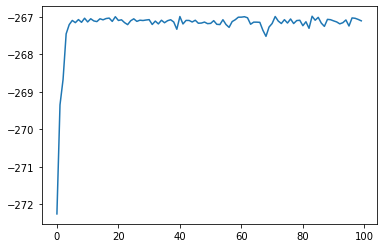

In [14]:
optim_reinforce = SLCVI(tree_log_probs,deepcopy(theta),pop_size)
optim_reinforce.learn(batch_size=10,
                      iters=1000,
                      alpha=0.1,
                      method="reinforce",
                      record_every=10,
                      pop_size=pop_size)

print("final theta:",optim_reinforce.theta)
print("final gradient:",optim_reinforce.theta.grad)
plt.plot(optim_reinforce.ELBO_ests)

# draw 10 random trees using a newick file

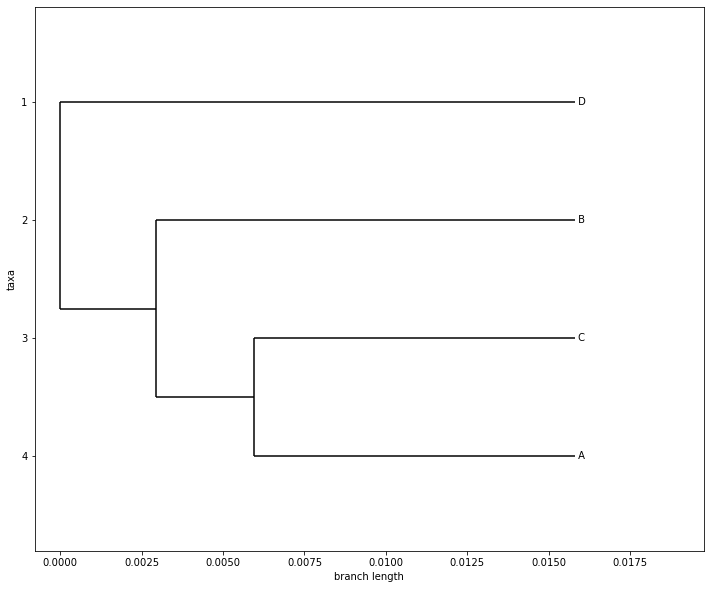

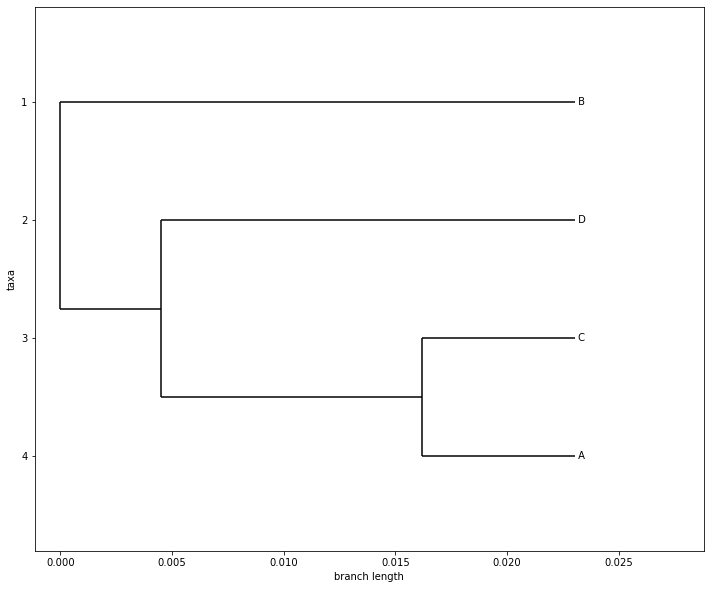

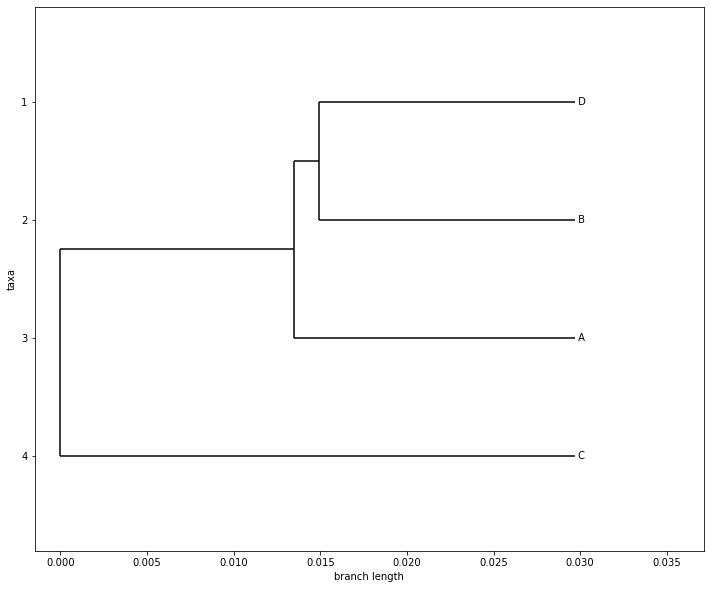

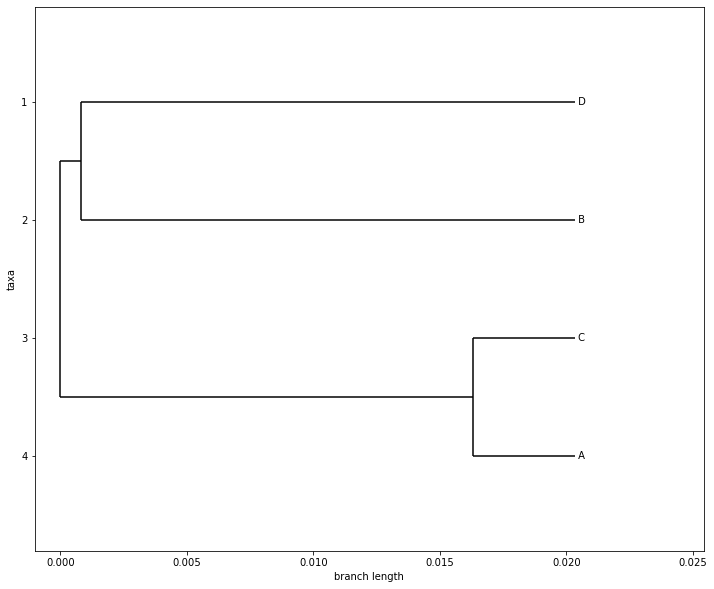

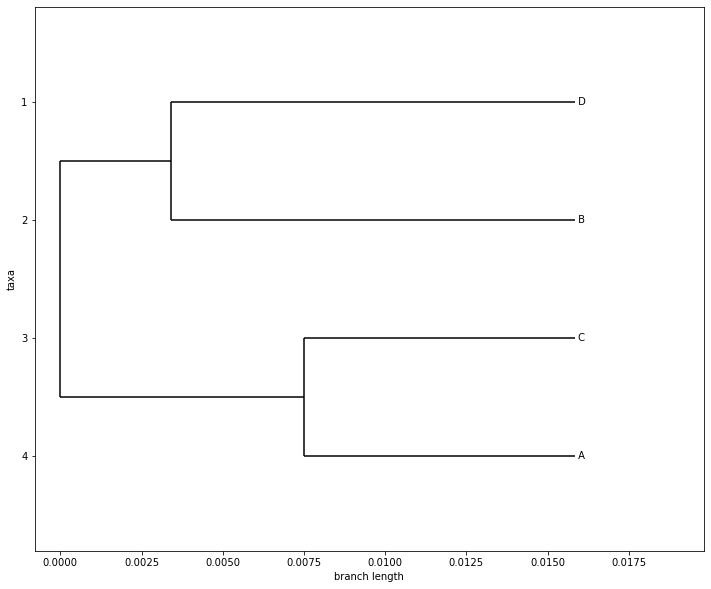

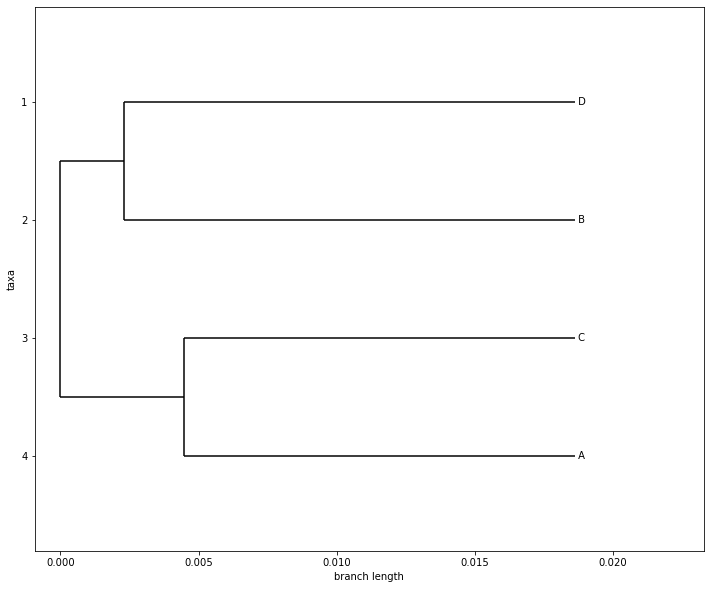

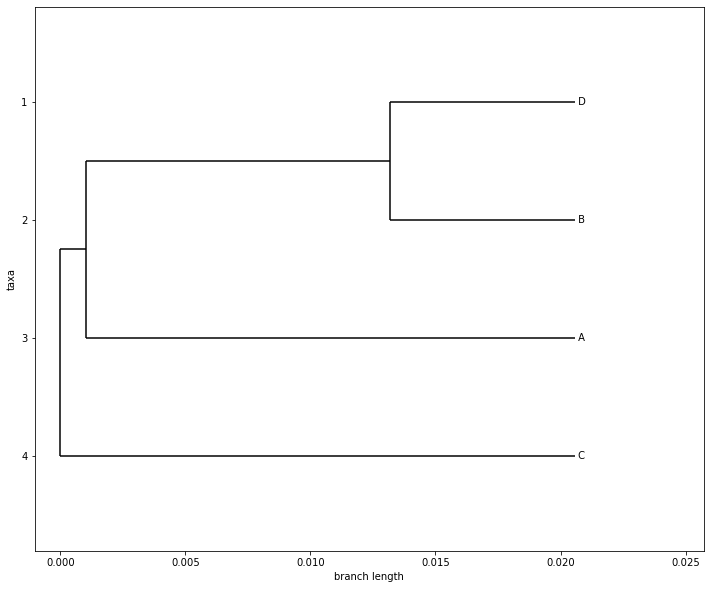

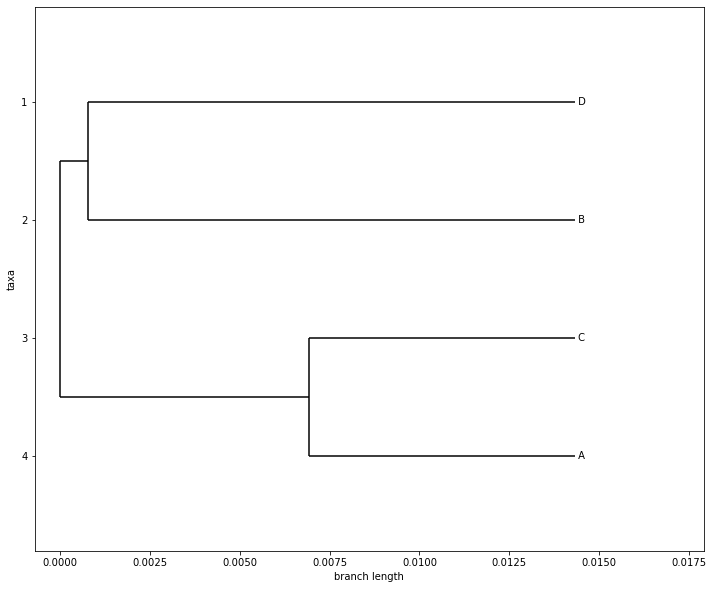

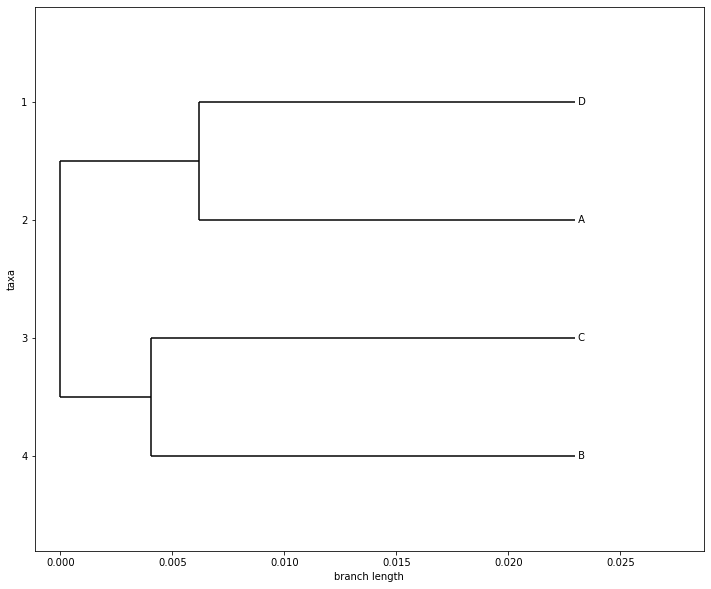

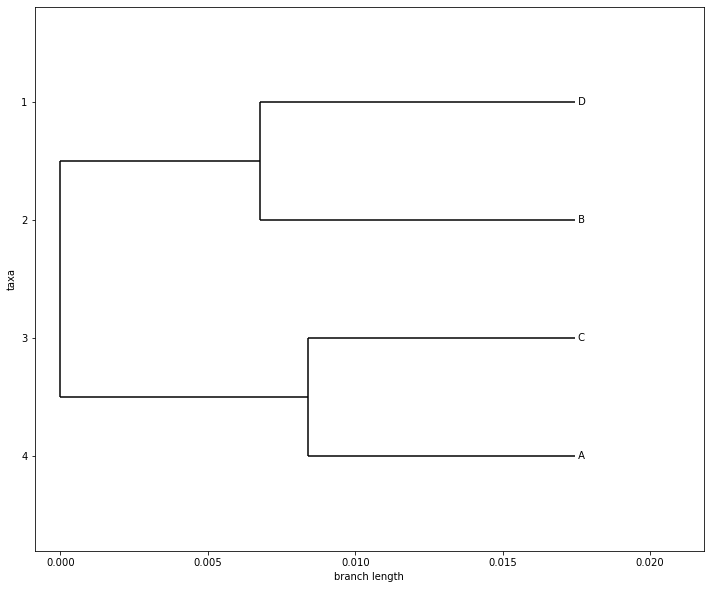

In [80]:
for _ in range(10):
    
    Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
    log_times = torch.exp(theta[1])*Z+theta[0]
    log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))
    tree = Tree(theta,log_times,
                deepcopy(tree_log_probs),
                pop_size=pop_size)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)
    fig.show()

# plot $\theta$

In [15]:
Z = torch.normal(mean=0.0,std=1.0,size=(10,n_species,n_species))

In [18]:
Z.shape[0]

10

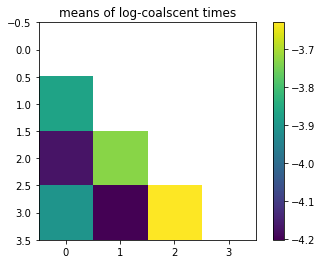

In [83]:
m = deepcopy(theta[0].detach())
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

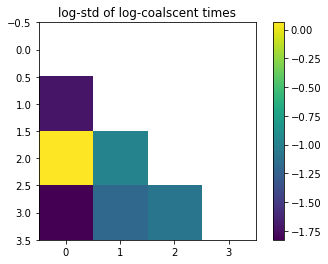

In [84]:
log_sig = deepcopy(theta[1].detach())
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()